# Somatic Symptom Fatigue Project: Neural Network Analysis

# Introduction

Fatigue is a prevalent somatic symptom that affects daily functioning and quality of life, particularly among young adults and students. Despite its non-specific nature, fatigue is frequently reported in both clinical and non-clinical settings and has been linked to a variety of psychological, social, and physiological factors. This project investigates the extent to which psychosocial and demographic variables can predict the presence of fatigue using supervised machine learning techniques, with a specific focus on neural network modeling.

# Literature review
Fatigue is often associated with significant reductions in quality of life and increased healthcare use. Prior research has identified multiple predictors of fatigue across clinical and community samples. In large population-based studies, fatigue has been significantly predicted by stressful life events, chronic illnesses, and psychological traits such as anxiety and neuroticism, with physical conditions explaining more variance than mental disorders alone (Creed et al., 2022). These findings underscore the multidimensional nature of fatigue etiology.

Symptom count has also been shown to be a reliable predictor of poor health outcomes and healthcare utilization, suggesting that modeling symptoms individually—rather than solely using aggregate diagnostic categories—may provide more nuanced insights (Tomenson et al., 2013). Clinical studies further highlight that fatigue, as a persistent somatic symptom (PSS), is influenced by both medical and psychosocial factors. For example, in cardiac populations, fatigue severity is shaped by gender, age, depressive and anxiety symptoms, and disease burden, reinforcing the need for a biopsychosocial perspective in understanding this symptom (Clifford et al., 2024).

Moreover, research from the SOMACROSS research unit has emphasized perceived stress as a modifiable risk factor for persistent somatic symptoms such as fatigue. Chronic stress exposure, particularly when perceived as uncontrollable, appears to exacerbate symptom experience and reporting (Löwe et al., 2022). Collectively, these studies demonstrate that fatigue is a complex, multifactorial symptom with overlapping biological, psychological, and social determinants.

### Dataset
This analysis uses data from the Experience and Attitudes of Mental Health in International Students (EAMMi2) dataset published in the Journal of Open Psychology Data (Grahe et al., 2018). The dataset includes responses from international university students on a variety of psychological and demographic measures.

**Sample**: Over 900 participants from 31 universities in the UK, EU, and beyond.
Variables: demographic information, and psychosocial measures.
Outcome variable: Symptom 12 (fatigue), from the Patient Health Questionnaire (PHQ-15), recoded into a binary variable indicating presence (1) or absence (0) of the symptom.
This dataset is particularly valuable because it captures a broad range of psychosocial and demographic factors, making it suitable for predictive modeling of somatic symptoms such as fatigue.

## Approach

Type of model: A feed-forward neural network is used for classification. The model is trained to predict a binary outcome: fatigue present (1) vs. fatigue absent (0).

Outcome variable: Symptom 12 (fatigue) is derived from the Patient Health Questionnaire (PHQ) dataset and is coded as a binary variable.

Predictors: Psychosocial (e.g., stress levels, emotional well-being) and demographic variables (e.g., age, sex, education) serve as predictors. These variables were selected based on prior evidence linking them to fatigue and related symptoms.

Evaluation Metrics: Model performance was assessed using accuracy, AUC, balanced accuracy, F1 score, and confusion matrix values to address class imbalance and prediction calibration

Model calibration and class imbalance were explicitly addressed during training through dropout regularization, early stopping, and metric selection. Results are interpreted using both performance metrics and SHAP values to identify the most influential predictors.



# Data Preparation


In [91]:
# !pip install torch
# !pip install keras
# !pip install tensorflow

In [92]:
# Core packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display tools
from IPython.display import Markdown

# preprocessing and pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# feature selection
from sklearn.feature_selection import SelectKBest, f_classif

# metrics
from sklearn.metrics import (
    classification_report, roc_auc_score, confusion_matrix,
    RocCurveDisplay, accuracy_score, roc_curve, auc
)
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.impute import SimpleImputer

# neural networking
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import os

import keras
from keras import layers, optimizers

import shap




@tbl-main-experpt shows a sample of the original dataset, which includes all recorded variables.

In [94]:
#| label: tbl-main-experpt
#| tbl-cap: "This table desplays random 2 rows of the data and transpose for eacy to read"
#| tbl-num: true

data = pd.read_excel("data/EAMMi2-Data1.2.xlsx", sheet_name="EAMMi2_Data")

data.sample(2)

,StartDate,EndDate,Status,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,RecipientFirstName,...,place,Q81,Q81_First Click,Q81_Last Click,Q81_Page Submit,Q81_Click Count,comments,affiliation,response_bias_SUM,school_coded
90,2016-12-01 19:59:43,2016-12-01 20:28:37,0,100,1733,1,2016-12-01 20:28:39,R_2pJI2dNRgEGHVwx,NaN,NaN,...,5.0,USA,2.801,19.106,19.668,5.0,I have completed this survey,adamsstate,1,adamsstate
318,2016-05-22 15:44:38,2016-05-22 16:01:45,0,100,1027,1,2016-05-22 16:01:47,R_1dyoLztJ9flDhsK,NaN,NaN,...,12.0,United States,14.686,25.296,34.922,3.0,I have completed this survey,bradley,2,University of Missouri


This data has 328 columns and 3182 rows.

The EAMMi2 (Emerging Adulthood Measured at Multiple Institutions) dataset is a publicly available multi-site study involving over 3,000 undergraduate students across more than 30 institutions. It includes responses to a wide array of validated psychological and social questionnaires, such as the Patient Health Questionnaire (PHQ), Mindfulness scale, Perceived Stress Questionnaire, and others. The dataset also captures detailed demographic information, allowing for rich exploratory and predictive modeling of psychosocial constructs.

In [96]:
data.shape

(3182, 328)

In [97]:
codebook = pd.read_excel("data/EAMMi2-Data1.2-Codebook.xlsx").set_index('Variable Name')

The variables listed in the codebook @tbl-factor_created-codebook represent composite measures that I constructed from raw item-level responses within the EAMMi2 dataset. These variables were designed to capture a range of psychological and demographic characteristics theoretically relevant to the experience of somatic symptoms. Psychological predictors include mean scores from validated self-report instruments, such as identity development (IDEA-8), perceived stress, social support, mindfulness, self-efficacy, need to belong, and subjective well-being. Additional variables reflect interpersonal dimensions, including narcissistic traits (NPI-13), interpersonal exploitativeness, and transgressions. Social media use was assessed through three dimensions: maintaining connections, forming new connections, and information seeking.

Demographic and attitudinal variables include disability identity, belief in the American dream, and the importance placed on marriage. I also recoded two categorical variables, parental marital status and sibling presence, to facilitate inclusion in statistical models. This curated and theoretically grounded set of predictors allows for a nuanced investigation of individual differences in somatic symptom reporting, particularly fatigue, in a young adult population.

In [99]:
# Recode sibling variable
data['sibling_c'] = data['sibling'].apply(lambda x: -0.5 if x == 1 else 0.5)

# Rename and process marriage variables
data = data.rename(columns={'marriage2': 'marriage_importance', 'marriage5': 'parental_marriage'})
data = pd.concat([data, pd.get_dummies(data['parental_marriage'].astype('category'),
                                      prefix='parental_marriage', drop_first=True)], axis=1)

# Compute scale means
scales = {
    'idea_m': [f'IDEA_{i}' for i in range(1, 9)],
    'moa_achievement_m': [f'moa1#2_{i}' for i in range(1, 11)] + [f'moa2#1_{i}' for i in range(1, 11)],
    'moa_importance_m': [f'moa2#1_{i}' for i in range(1, 11)] + [f'moa2#2_{i}' for i in range(1, 11)],
    'stress_m': [f'stress_{i}' for i in range(1, 11)],
    'support_m': [f'support_{i}' for i in range(1, 13)],
    'belong_m': [f'belong_{i}' for i in range(1, 11)],
    'mindful_m': [f'mindful_{i}' for i in range(1, 16)],
    'efficacy_m': [f'efficacy_{i}' for i in range(1, 11)],
    'npi_m': [f'NPI{i}' for i in range(1, 14)],
    'exploit_m': [f'exploit_{i}' for i in range(1, 4)],
    'disability_m': [f'Q10_{i}' for i in range(1, 16)] + ['Q11'] + [f'Q14_{i}' for i in range(1, 7)],
    'social_conn_m': [f'SocMedia_{i}' for i in range(1, 6)],
    'social_new_m': [f'SocMedia_{i}' for i in range(6, 10)],
    'social_info_m': [f'SocMedia_{i}' for i in range(10, 12)],
    'swb_m': [f'swb_{i}' for i in range(1, 7)],
    'transgres_m': [f'transgres_{i}' for i in range(1, 5)],
    'usdream_m': ['usdream_1', 'usdream_2']
}

for name, items in scales.items():
    valid_items = [item for item in items if item in data.columns]
    data[name] = data[valid_items].mean(axis=1, skipna=True)

# Select final columns
final_data = data[[col for col in data.columns if
                  col.endswith(('_m', '_c')) or
                  col in ['marriage_importance', 'parental_marriage'] or
                  col.startswith(('parental_marriage_', 'sex_'))]]

In [100]:
#| label: tbl-factor_created-codebook
#| tbl-cap: "This is the codebook for all the variables I created."
#| tbl-num: true
#| echo: true
#| output-location: slide

codebook_created = {
    'idea_m': "Mean score: Identity Exploration and Development Assessment (IDEA-8)",
    'moa_achievement_m': "Mean score: Markers of Adulthood - Achievement subscale",
    'moa_importance_m': "Mean score: Markers of Adulthood - Importance subscale",
    'stress_m': "Mean score: Perceived Stress Scale",
    'support_m': "Mean score: Perceived Social Support",
    'belong_m': "Mean score: Need to Belong Scale",
    'mindful_m': "Mean score: Mindfulness Scale",
    'efficacy_m': "Mean score: Efficacy/Competence Scale",
    'npi_m': "Mean score: Narcissistic Personality Inventory (NPI-13)",
    'exploit_m': "Mean score: Interpersonal Exploitativeness Scale",
    'disability_m': "Mean score: Disability Identity & Status items",
    'social_conn_m': "Mean score: Social Media Use - Maintaining Connections",
    'social_new_m': "Mean score: Social Media Use - Making New Connections",
    'social_info_m': "Mean score: Social Media Use - Information Seeking",
    'swb_m': "Mean score: Subjective Well-Being",
    'transgres_m': "Mean score: Interpersonal Transgressions",
    'usdream_m': "Mean score: American Dream (Importance and Belief in Achievability)",
    'sibling_c': "Recode: -0.5 = no siblings, +0.5 = at least one sibling",
    'marriage_importance': "Importance of getting married (1-5 scale)",
    'parental_marriage': "Parental marriage status (categorical)"

}


codebook_df = pd.DataFrame({
    'Variable': list(codebook_created.keys()),
    'Description': list(codebook_created.values())
})


Markdown(codebook_df.to_markdown())

|    | Variable            | Description                                                          |
|---:|:--------------------|:---------------------------------------------------------------------|
|  0 | idea_m              | Mean score: Identity Exploration and Development Assessment (IDEA-8) |
|  1 | moa_achievement_m   | Mean score: Markers of Adulthood - Achievement subscale              |
|  2 | moa_importance_m    | Mean score: Markers of Adulthood - Importance subscale               |
|  3 | stress_m            | Mean score: Perceived Stress Scale                                   |
|  4 | support_m           | Mean score: Perceived Social Support                                 |
|  5 | belong_m            | Mean score: Need to Belong Scale                                     |
|  6 | mindful_m           | Mean score: Mindfulness Scale                                        |
|  7 | efficacy_m          | Mean score: Efficacy/Competence Scale                                |
|  8 | npi_m               | Mean score: Narcissistic Personality Inventory (NPI-13)              |
|  9 | exploit_m           | Mean score: Interpersonal Exploitativeness Scale                     |
| 10 | disability_m        | Mean score: Disability Identity & Status items                       |
| 11 | social_conn_m       | Mean score: Social Media Use - Maintaining Connections               |
| 12 | social_new_m        | Mean score: Social Media Use - Making New Connections                |
| 13 | social_info_m       | Mean score: Social Media Use - Information Seeking                   |
| 14 | swb_m               | Mean score: Subjective Well-Being                                    |
| 15 | transgres_m         | Mean score: Interpersonal Transgressions                             |
| 16 | usdream_m           | Mean score: American Dream (Importance and Belief in Achievability)  |
| 17 | sibling_c           | Recode: -0.5 = no siblings, +0.5 = at least one sibling              |
| 18 | marriage_importance | Importance of getting married (1-5 scale)                            |
| 19 | parental_marriage   | Parental marriage status (categorical)                               |

In addition to the psychological scales that were processed into mean scores, the second codebook @tbl-factor_unchanged-codebook describes the variables retained from the original EAMMi2 dataset without modification. These include sex (coded as 1 = male, 2 = female, 3 = other), edu (education level from high school to graduate degree), race (categorical coding for racial/ethnic identity), income (ordinal indicator of household income). The outcome variable physSx_12 (fatigue) was also retained in its original form before being recoded into a binary variable to indicate symptom presence (≥ 2 = symptom present). These variables were selected based on theoretical relevance to somatic symptom experiences and were not transformed beyond basic recoding or dummy encoding when necessary for modeling.

In [102]:
#| label: tbl-factor_unchanged-codebook
#| tbl-cap: "This is the codebook of the variables retained without modification from the raw dataset."
#| tbl-num: true
#| echo: true
#| output-location: slide

Markdown(
    codebook
    .loc[['sex', 'edu', 'race', 'income', 'physSx_12']]
    [['Question text', 'responses']]
    .to_markdown()
)

| Variable Name   | Question text                                                                    | responses                                                            |
|:----------------|:---------------------------------------------------------------------------------|:---------------------------------------------------------------------|
| sex             | What is your gender?                                                             | 1-male, 2-female, 3-other                                            |
| edu             | Which of the following choices best describes your educational level/attainment? | 1-high school, 9 completed graduate degree                           |
| race            | What is your racial/ethnic group (check all the apply)? - Selected Choice        | 1-1White, 2-Black, 3-Hispanic, 4- Asian, 5 -Native American, 6-other |
| income          | Please indicate your current household income in U.S. dollars                    | 1-rather not say, 2 -under 20,000, 9- over 1 million                 |
| physSx_12       | Feeling tired or having low energy                                               | 1-not bothered at all, 3 bothered a lot                              |

The outcome variable physSx_12, which reflects the severity of a specific somatic symptom, shows a right-skewed distribution. The majority of responses fall in the moderate (2) and high (3) categories, with fewer individuals reporting mild symptoms (1). This class imbalance may influence model performance and will be considered during model evaluation.

For this project, we selected Item 12 (fatigue) from the PHQ somatic symptom inventory as the primary outcome of interest. This symptom was chosen due to its clinical relevance and sufficient variability in the sample, despite some imbalance in outcome distribution. A binary outcome variable was created to indicate whether the symptom was present (i.e., the participant reported experiencing fatigue “slightly” or “a lot,” score ≥ 2) or not present (“not at all,” score = 1). To account for the imbalance, classification models were adjusted using class weights. Separate logistic regression and random forest models were trained using mean scores from psychological scales and demographic variables as predictors to identify key risk factors associated with fatigue.

In [104]:
data["physSx_12"].value_counts()

physSx_12
3.0    1552
2.0    1220
1.0     405
Name: count, dtype: int64

## Variables and Measures

### Outcome Variable

The outcome variable were assessed using item 12 from the **Patient Health Questionnaire (PHQ)**. Responses were recoded into a binary variable, where a score of 2 or higher was considered symptomatic (coded as 1), and a score of 1 indicated no significant fatigue symptoms (coded as 0). This binary formulation was chosen due to its moderate class balance and clinical relevance.

### Psychological Predictors

All psychological variables were computed as mean scores across item-level responses, provided that a sufficient proportion of items (≥70%) were present. The following scales were included:

- **IDEA-8**: Identity exploration and development (8 items)
- **Markers of Adulthood**:
  - Achievement subscale (10 items)
  - Importance subscale (10 items)
- **Perceived Stress Scale** (10 items)
- **Perceived Social Support** (12 items)
- **Need to Belong Scale** (10 items)
- **Mindfulness Scale** (15 items)
- **Self-Efficacy/Competence** (10 items)
- **Narcissistic Personality Inventory (NPI-13)** (13 items)
- **Interpersonal Exploitativeness** (3 items)
- **Disability Identity and Status** (combination of 22 items from Q10, Q11, and Q14)
- **Social Media Use**:
  - Maintaining connections (5 items)
  - Making new connections (4 items)
  - Seeking information (2 items)
- **Subjective Well-Being** (6 items)
- **Interpersonal Transgressions** (4 items)
- **Belief in and importance of the American Dream** (2 items)

### Demographic and Attitudinal Predictors

- **Sex** (male, female, other; categorical)
- **Education level**
- **Race/Ethnicity**
- **Household income**
- **School attended**
- **Parental marriage status** (recoded into categorical dummy variables)
- **Siblings** (recoded: -0.5 = no siblings, 0.5 = at least one sibling)
- **Importance of marriage** (single-item rating)

These variables represent a theoretically grounded and diverse set of predictors for modeling somatic symptom risk, with particular focus on psychological and social functioning within a young adult population. @tbl-new-experpt shows the an experpt of the final data we are using.

In [106]:
# Binary outcome for fatigue:
# 1 = symptom present (score ≥ 2)
# 0 = symptom not present (score = 1)
data['fatigue_binary'] = (data['physSx_12'] >= 2).astype(int)

In [107]:
#| label: tbl-new-experpt
#| tbl-cap: "This table desplays random 2 rows of the new subset I created and transpose for eacy to read"
#| tbl-num: true

constructed_vars = [
    'idea_m', 'moa_achievement_m', 'moa_importance_m', 'stress_m', 'support_m',
    'belong_m', 'mindful_m', 'efficacy_m', 'npi_m', 'exploit_m', 'disability_m',
    'social_conn_m', 'social_new_m', 'social_info_m', 'swb_m', 'transgres_m',
    'usdream_m', 'sibling_c', 'marriage_importance', 'parental_marriage'
]
raw_demographics = ['sex', 'edu', 'race', 'income']

final_vars = constructed_vars + raw_demographics

final_data = data[final_vars].copy()

final_data.sample(2).transpose()

,968,700
idea_m,3.75,3.875
moa_achievement_m,2.7,2.45
moa_importance_m,2.7,2.6
stress_m,3.2,3.4
support_m,7.0,5.416667
belong_m,3.4,3.8
mindful_m,4.133333,3.6
efficacy_m,2.7,3.5
npi_m,1.461538,1.692308
exploit_m,1.0,1.333333


@tbl-summary presents descriptive statistics for all study variables. Across variables, missing data were minimal (0–25 cases).  Standard deviations indicate varying levels of dispersion, with the lowest variability observed for *npi\_m* (SD = 0.12) and the highest for *exploit\_m* (SD = 1.37). Categorical variables such as sex and sibling count showed appropriate coding ranges. Income and education variables were right-skewed, with maximum values of 9. Overall, distributions and missingness were acceptable for further analyses.


In [109]:
#| label: tbl-summary
#| tbl-cap: “Summary Statistics”
#| tbl-num: true

stats = final_data.describe().transpose().round(3)
stats['missing'] = final_data.isnull().sum()
stats = stats[['count', 'missing', 'mean', 'std', 'min', '50%', 'max']]
stats


,count,missing,mean,std,min,50%,max
idea_m,3180.0,2,3.571,0.383,1.000,3.625,4.000
moa_achievement_m,3181.0,1,2.658,0.299,1.500,2.650,4.000
moa_importance_m,3180.0,2,2.778,0.296,1.650,2.800,4.000
stress_m,3177.0,5,3.266,0.408,1.000,3.300,5.000
support_m,3180.0,2,5.530,1.135,1.000,5.750,7.000
belong_m,3179.0,3,3.312,0.496,1.000,3.400,5.000
mindful_m,3177.0,5,3.710,0.843,1.133,3.733,6.000
efficacy_m,3180.0,2,3.125,0.450,1.000,3.100,4.000
npi_m,3179.0,3,1.545,0.124,1.000,1.538,2.000
exploit_m,3179.0,3,2.387,1.374,1.000,2.000,7.000


# EDA


We now proceed with the exploratory data analysis (EDA) to examine variable relationships and detect potential outliers patterns that may inform subsequent modeling.

@fig-hist-numeric displays the distributions of all numeric variables in the dataset. Most variables showed approximately normal or slightly skewed distributions (e.g., *mindful\_m*, *efficacy\_m*, *moa\_achievement\_m*), while others were highly skewed (e.g., *support\_m*, *exploit\_m*, *transgres\_m*). Categorical variables (e.g., *sex*, *sibling\_c*, *edu*) showed clear discrete patterns, reflecting limited response options. Some variables (e.g., *social\_info\_m*, *marriage\_importance*) exhibited multimodal or uneven distributions, suggesting clustering of responses. Overall, the figure indicates variability in distribution shapes across measures, which may inform modeling strategies.

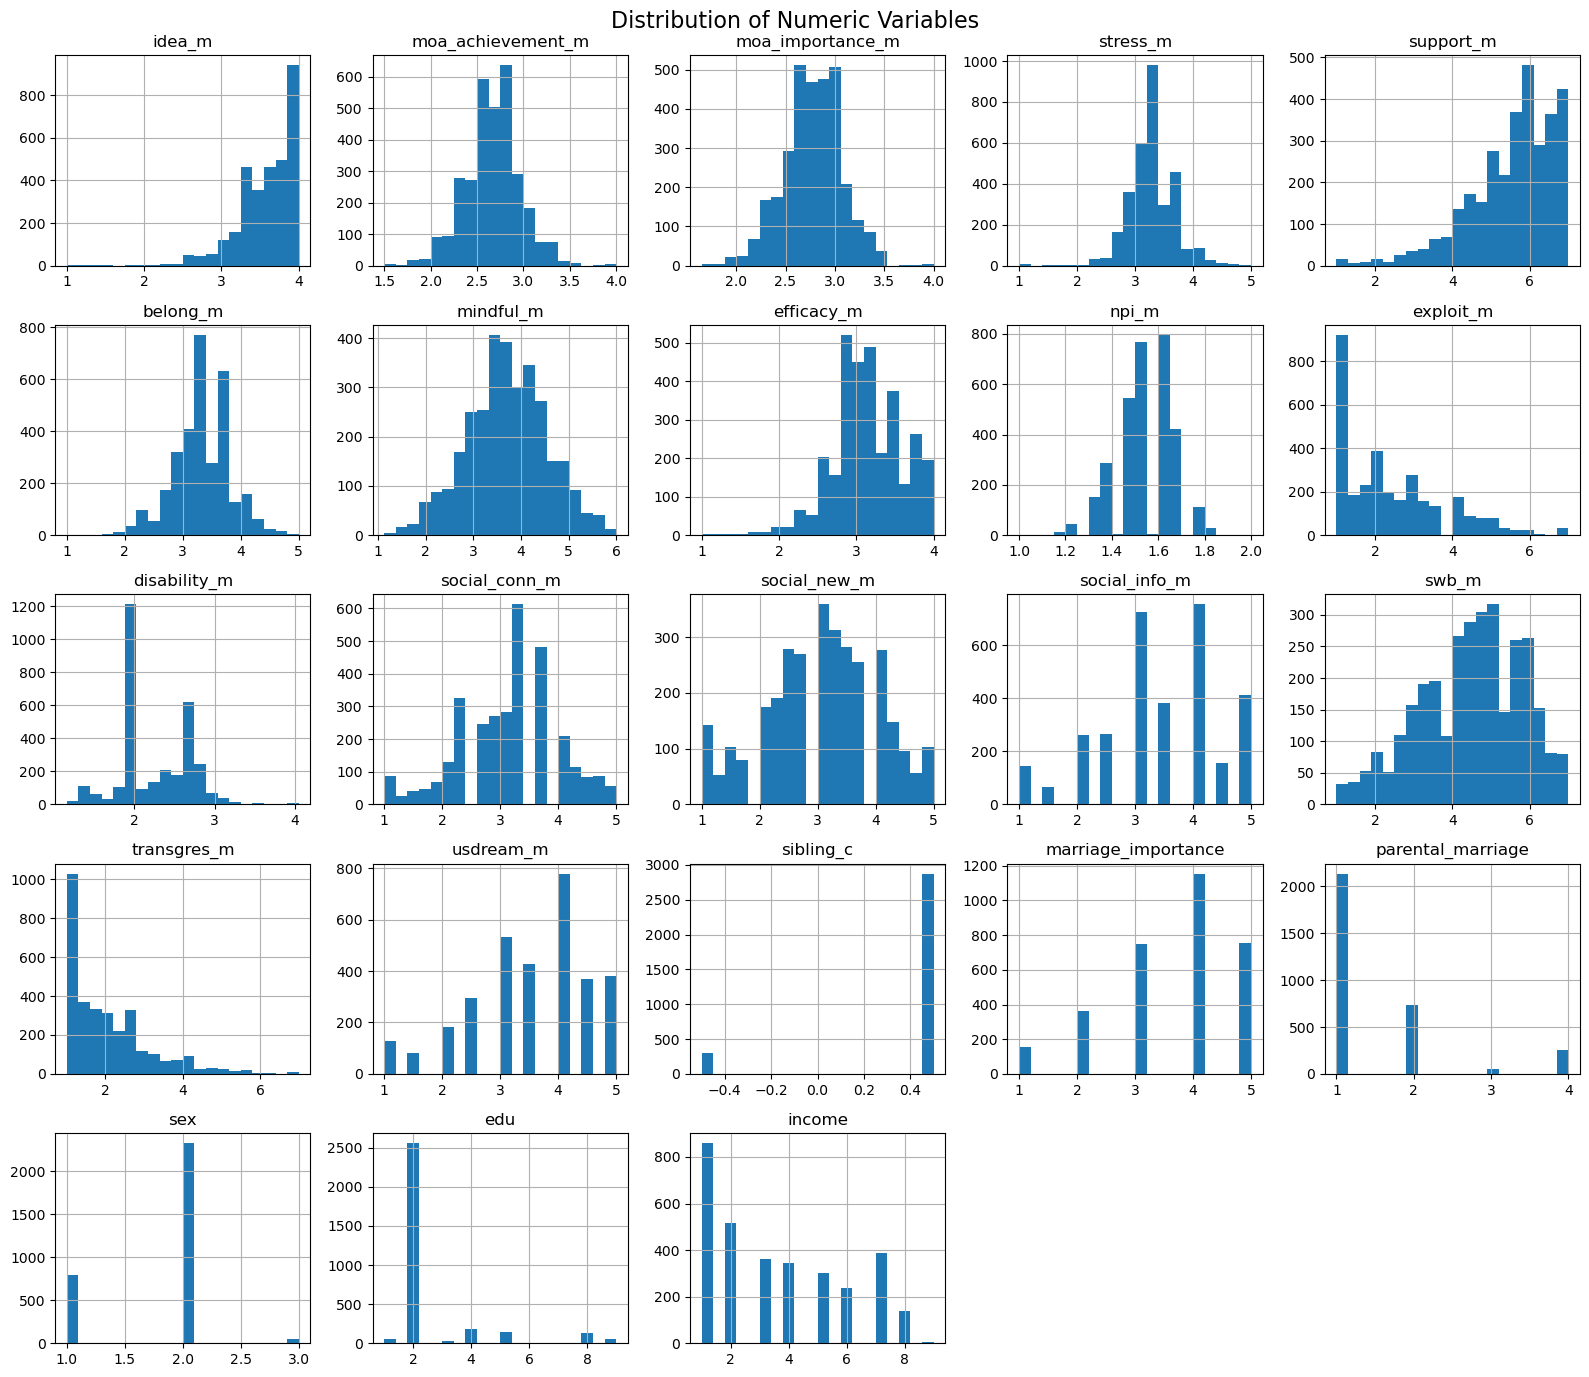

In [113]:
#| label: fig-hist-numeric
#| fig-cap: "Distribution of numeric variables across the final dataset."
#| fig-num: true

# Histograms for numeric variables
numeric_vars = final_data.select_dtypes(include=['float64', 'int64']).columns
final_data[numeric_vars].hist(figsize=(16, 14), bins=20)
plt.suptitle("Distribution of Numeric Variables", fontsize=16)
plt.tight_layout()
plt.show()

@fig-corr-heatmap presents a correlation matrix of numeric predictors, including the binary fatigue outcome. Most correlations were small to moderate, suggesting low multicollinearity among variables. Notably, *moa\_achievement\_m* and *moa\_importance\_m* were highly correlated (*r* = .85), indicating a strong relationship between these constructs. Moderate positive associations were observed between *support\_m* and both *swb\_m* (*r* = .47) and *belong\_m* (*r* = .40). Correlations with *fatigue\_binary* were generally weak, with the strongest negative correlation observed for *support\_m* (*r* = −.17). These findings offer preliminary insights into variable associations and guide further analysis.

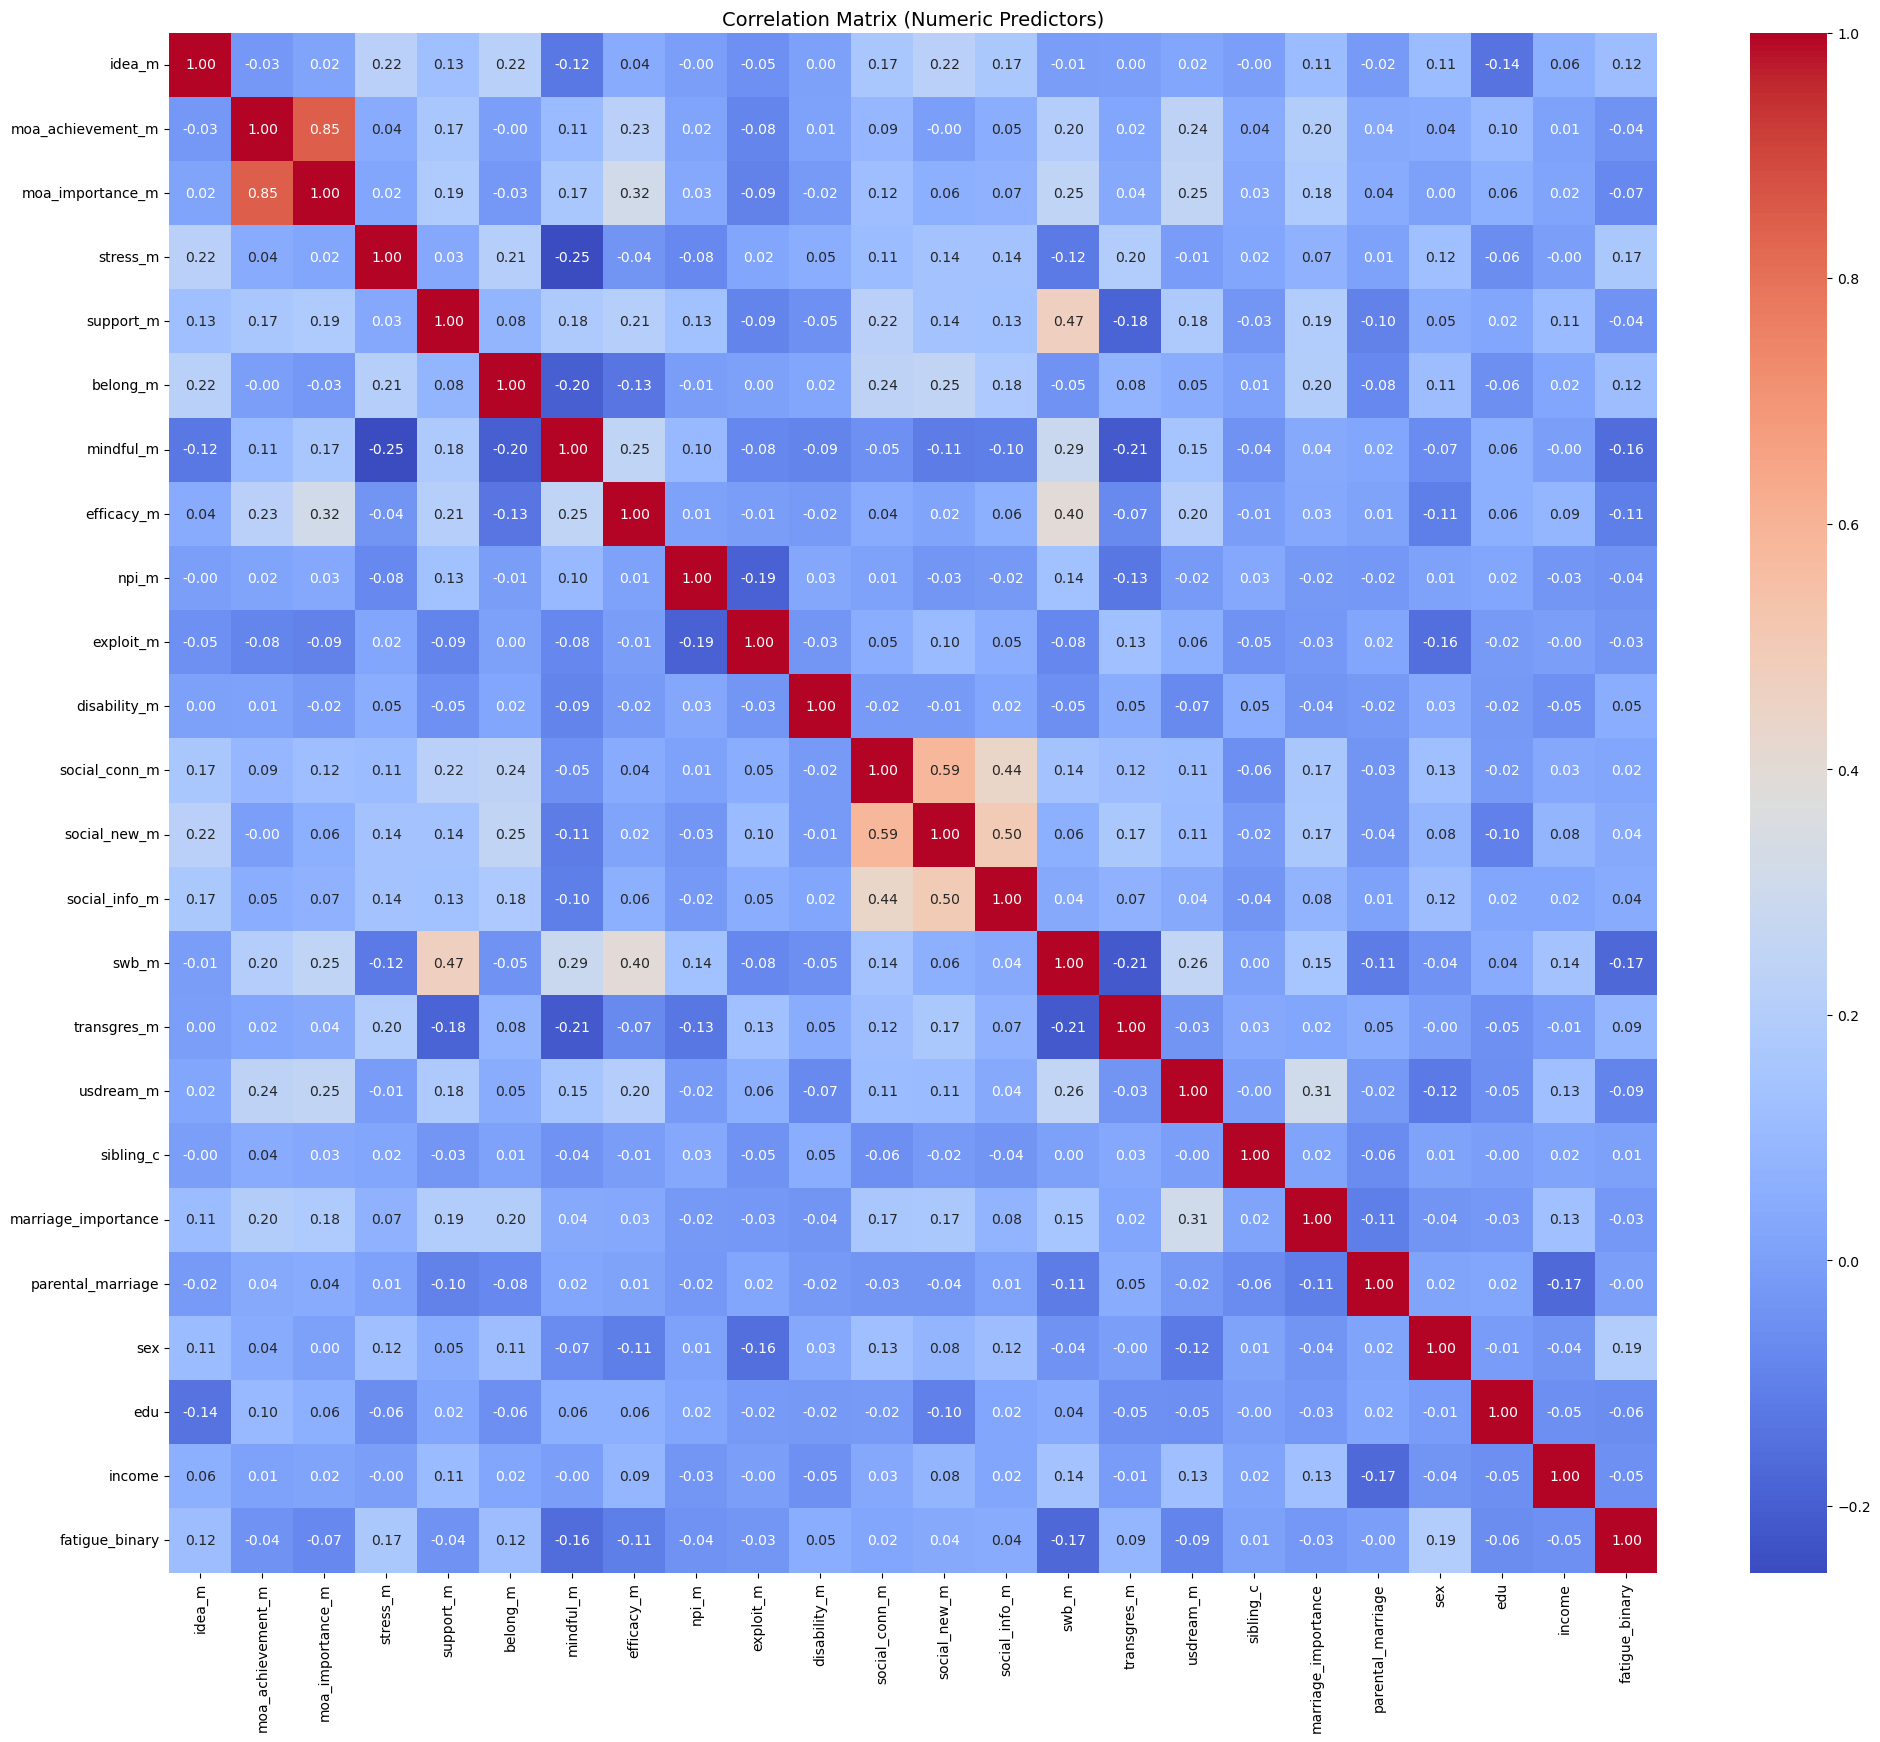

In [115]:
#| label: fig-corr-heatmap
#| fig-cap: "Correlation heatmap showing pairwise Pearson correlations. Stronger correlations appear in darker shades."
#| fig-num: true

# heatmap
final_data['fatigue_binary'] = data['fatigue_binary']
selected_vars = list(numeric_vars) + ['fatigue_binary']

plt.figure(figsize=(24, 20))
sns.heatmap(final_data[selected_vars].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix (Numeric Predictors)", fontsize=14)
plt.show()

#Train-Test Split
The dataset was split into training and test sets using a stratified sampling approach to preserve the class distribution of the binary fatigue outcome. A total of 3,132 complete cases were included, with 70% allocated to training (n = 2,192) and 30% to testing (n = 940). The target variable (fatigue_binary) was imbalanced, with 87.3% of participants coded as "1" and 12.7% coded as "0". This stratified split ensures both sets maintain the original class proportions, supporting more reliable model evaluation.

In [117]:
X = final_data.drop(columns=['fatigue_binary'], errors='ignore')  # safer drop
y = data['fatigue_binary']


model_data = X.join(y.rename('fatigue_binary')).dropna()

In [118]:
# Separate X and y
X_clean = model_data.drop(columns='fatigue_binary')
y_clean = model_data['fatigue_binary']

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean,
    test_size=0.3,
    random_state=45,
    stratify=y_clean
)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print(y_clean.value_counts(normalize=True))

Train shape: (2192, 24)
Test shape: (940, 24)
fatigue_binary
1    0.872605
0    0.127395
Name: proportion, dtype: float64


## Data Normalization
The data were preprocessed to prepare for model training. Non-numeric columns were identified and converted to numeric format, with commas replaced by decimal points. Missing values in the *race* variable were imputed using the most frequent category (mode). Following data cleaning, all predictor variables were standardized using `StandardScaler`, which was fit on the training set and applied to both training and test sets. This normalization step ensures that features are on a comparable scale, which is important for many machine learning algorithms.


In [120]:
# Identify non-numeric columns before scaling
non_numeric_cols = X_train.select_dtypes(exclude=['float64', 'int64']).columns

# Convert identified columns to numeric, replacing commas with periods
for col in non_numeric_cols:
    X_train[col] = X_train[col].astype(str).str.replace(',', '.', regex=False)
    X_test[col] = X_test[col].astype(str).str.replace(',', '.', regex=False)

X_train[non_numeric_cols] = X_train[non_numeric_cols].apply(pd.to_numeric, errors='coerce')
X_test[non_numeric_cols] = X_test[non_numeric_cols].apply(pd.to_numeric, errors='coerce')

# Impute missing values in the 'race' column with the mode (most frequent value)
# Fit imputer on training data and transform both train and test
imputer_race = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X_train['race'] = imputer_race.fit_transform(X_train[['race']])
X_test['race'] = imputer_race.transform(X_test[['race']])


# Step 1: Initialize the scaler
scaler = StandardScaler()

# Step 2: Fit the scaler on the training data and transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Evaluation

## Tensorflow
Model performance was first evaluated using a neural network built with TensorFlow. Accuracy and area under the ROC curve (AUC) served as the primary evaluation metrics. A confusion matrix and classification report offered further insight into precision, recall, and F1 scores. Visual diagnostics—such as loss and accuracy over training epochs, a receiver operating characteristic (ROC) curve, and a histogram of predicted probabilities—were used to assess model fit, class discrimination, and prediction confidence.

In [122]:
# Build a simple model
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Check for and handle potential NaN values in X_train_scaled
if np.isnan(X_train_scaled).any():
    print("NaN values found in X_train_scaled. Imputing with the mean of the scaled training data.")
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    X_train_scaled_imputed = imputer.fit_transform(X_train_scaled)
else:
    X_train_scaled_imputed = X_train_scaled


# Train
history = model.fit(
    X_train_scaled_imputed, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    verbose=1
)

Epoch 1/30


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7884 - loss: 0.5311 - val_accuracy: 0.8770 - val_loss: 0.4400
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - accuracy: 0.8648 - loss: 0.4278 - val_accuracy: 0.8770 - val_loss: 0.3924
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - accuracy: 0.8711 - loss: 0.4104 - val_accuracy: 0.8770 - val_loss: 0.3763
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - accuracy: 0.8711 - loss: 0.3925 - val_accuracy: 0.8770 - val_loss: 0.3687
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - accuracy: 0.8688 - loss: 0.3770 - val_accuracy: 0.8770 - val_loss: 0.3641
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step - accuracy: 0.8682 - loss: 0.3732 - val_accuracy: 0.8770 - val_loss: 0.3623
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - accuracy: 0.8722 - loss: 0.3700 - val_accuracy: 0.8770 - val_loss: 0.3584
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - accuracy: 0.8739 - loss: 0.3592 - val_accuracy: 0.8770 - val_lo

@fig-loss-acc shows the training and validation loss (left) and accuracy (right) across 30 training epochs for the neural network model. Training loss steadily decreased and stabilized, while validation loss plateaued early, indicating good convergence without overfitting. Accuracy for both training and validation sets increased rapidly and remained stable around 87%, suggesting the model generalized well to unseen data. These patterns reflect effective learning and a well-tuned model.

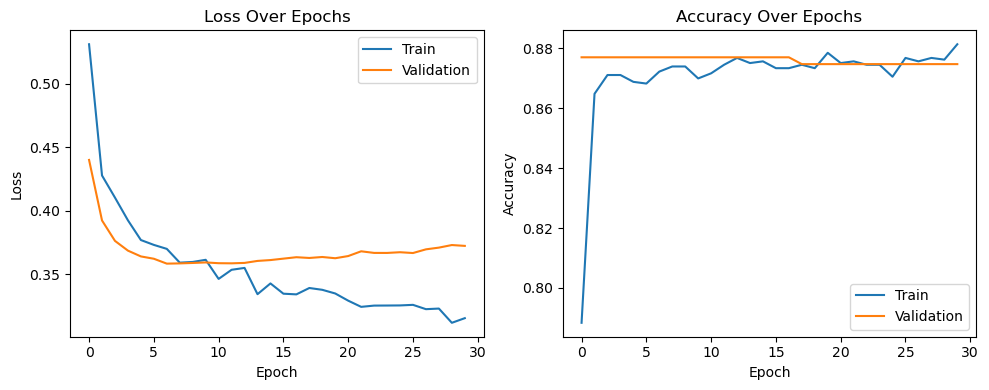

In [124]:
#| label: fig-loss-acc
#| fig-cap: "Training and Validation Loss and Accuracy Across Epochs for Neural Network Model"
#| fig-num: true

# Plot training and validation loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


As shown in @tbl-nn-metrics, the neural network model achieved a test accuracy of 87.2% and an area under the curve (AUC) of 0.73, indicating good overall performance. However, the classification report revealed a critical limitation: the model failed to identify any instances of the minority class (label = 0), resulting in a precision, recall, and F1-score of 0.00 for that class. In contrast, the model demonstrated strong performance on the majority class (label = 1), with a recall of 1.00 and an F1-score of 0.93. These results suggest that while the model performs well in aggregate, it is highly imbalanced in its predictions and unable to detect the minority class, likely due to class imbalance in the training data.


In [126]:
#| label: tbl-nn-metrics
#| tbl-cap: "Performance metrics for the neural network model predicting fatigue."
#| tbl-num: true

if np.isnan(X_test_scaled).any():
    imputer = SimpleImputer(strategy='mean')
    imputer.fit(X_train_scaled)
    X_test_scaled_imputed = imputer.transform(X_test_scaled)
else:
    X_test_scaled_imputed = X_test_scaled

# Predict
y_pred_prob = model.predict(X_test_scaled_imputed).flatten()
y_pred_class = (y_pred_prob >= 0.5).astype(int)

# Calculate metrics
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_class),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred_class),
    "AUC": roc_auc_score(y_test, y_pred_prob),
    "F1 Score": f1_score(y_test, y_pred_class),
    "Precision": precision_score(y_test, y_pred_class),
    "Recall": recall_score(y_test, y_pred_class),
}

# Create a metrics table
metrics_df = pd.DataFrame({
    "Metric": list(metrics.keys()),
    "Value": [round(v, 3) for v in metrics.values()]
})

metrics_df

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step


,Metric,Value
0,Accuracy,0.872
1,Balanced Accuracy,0.500
2,AUC,0.733
3,F1 Score,0.932
4,Precision,0.872
5,Recall,1.000


@fig-roc presents the receiver operating characteristic (ROC) curve for the neural network model. The area under the curve (AUC) was 0.74, indicating fair discriminatory ability in distinguishing between participants with and without fatigue. The curve lies consistently above the diagonal reference line, suggesting the model performs better than random chance. However, the moderate AUC also reflects limitations in sensitivity, especially given the model’s failure to detect the minority class in the classification results.

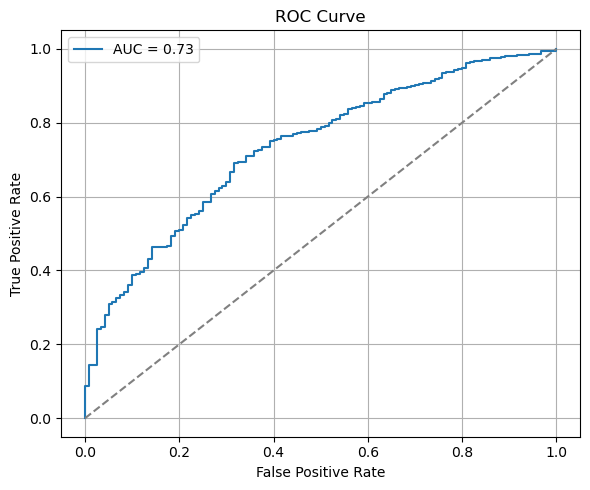

In [128]:
#| label: fig-roc
#| fig-cap: "Receiver Operating Characteristic (ROC) Curve for Neural Network Model"
#| fig-num: true

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


@fig-predicted-probabilities displays the distribution of predicted probabilities for fatigue (class 1) in the test set. The histogram shows that most predictions were concentrated at the higher end of the probability range, particularly above 0.85. This indicates that the model was highly confident in predicting the majority class. The absence of low-probability predictions suggests poor discrimination for identifying the minority class (no fatigue), consistent with earlier findings from the confusion matrix and classification report. This skewed probability distribution further highlights the model’s bias toward the dominant class.


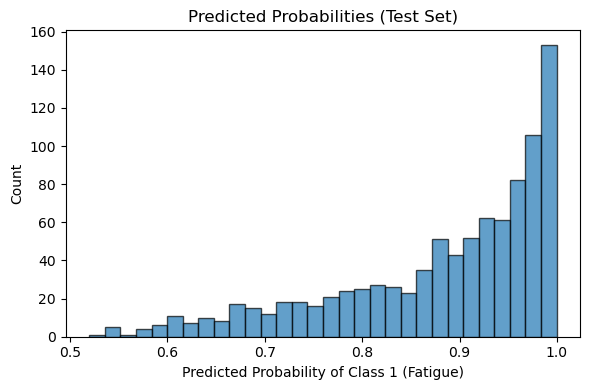

In [130]:
#| label: fig-predicted-probabilities
#| fig-cap: "Histogram of Predicted Probabilities for Fatigue Class (Test Set)"
#| fig-num: true

plt.figure(figsize=(6, 4))
plt.hist(y_pred_prob, bins=30, edgecolor='k', alpha=0.7)
plt.title("Predicted Probabilities (Test Set)")
plt.xlabel("Predicted Probability of Class 1 (Fatigue)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


## Keras 3 + PyTorch

The second neural network model was built using the Keras Sequential API and consisted of an input layer, two hidden layers (with 64 and 32 units, respectively), ReLU activations, and dropout regularization (rate = 0.3) to reduce overfitting. The output layer used a sigmoid activation to support binary classification. The model was compiled with the Adam optimizer (learning rate = 0.001) and binary cross-entropy loss. It was trained for 20 epochs with a batch size of 32 and 20% of the training data reserved for validation. The final test accuracy achieved was 87.2%, indicating strong overall predictive performance on the fatigue classification task.

In [133]:
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32
)


Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8260 - loss: 0.5367 - val_accuracy: 0.8770 - val_loss: 0.3905
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - accuracy: 0.8540 - loss: 0.4402 - val_accuracy: 0.8770 - val_loss: 0.3778
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - accuracy: 0.8654 - loss: 0.4145 - val_accuracy: 0.8770 - val_loss: 0.3851
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - accuracy: 0.8688 - loss: 0.3993 - val_accuracy: 0.8770 - val_loss: 0.3831
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - accuracy: 0.8711 - loss: 0.3956 - val_accuracy: 0.8770 - val_loss: 0.3700
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - accuracy: 0.8716 - loss: 0.3819 - val_accuracy: 0.8770 - val_loss: 0.3746
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - accuracy: 0.8716 - loss: 0.3746 - val_accuracy: 0.8770 - val_loss: 0.3822
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - accuracy: 0.8694 - loss: 0.3657 - val_accuracy: 0.87

In [134]:
# Predictions (probabilities → binary)
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print("Model Accuracy:", acc)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step
Model Accuracy: 0.8723404255319149


The evaluation of the Keras neural network model was conducted on the test set, with missing values imputed using the mean of the training data where necessary. Predicted probabilities were converted to binary class labels using a 0.5 threshold. The model achieved a test accuracy of 87.2% and an AUC of 0.74, indicating strong overall predictive performance and acceptable class discrimination. These results are consistent with earlier evaluation metrics, further confirming the model’s effectiveness in identifying fatigue cases.

In [136]:
# Impute missing values in the test set using the imputer fitted on the training data
if np.isnan(X_test).any().any():
    imputer = SimpleImputer(strategy='mean')
    imputer.fit(X_train) # Fit on training data
    X_test_imputed = imputer.transform(X_test)
else:
    X_test_imputed = X_test.values # Convert to numpy array if no imputation needed


# Predictions (probabilities → binary)
y_pred_proba = model.predict(X_test_imputed).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

#Metrics
acc = accuracy_score(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)


# Store results in a dictionary
results_dict = {
    'Metric': ['Accuracy', 'Balanced Accuracy', 'AUC', 'F1 Score', 'Precision', 'Recall'],
    'Value': [acc, balanced_acc, auc, f1, precision, recall]
}

# Create DataFrame and round values
results_df = pd.DataFrame(results_dict)
results_df['Value'] = results_df['Value'].round(3)


results_df

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


,Metric,Value
0,Accuracy,0.872
1,Balanced Accuracy,0.500
2,AUC,0.723
3,F1 Score,0.932
4,Precision,0.872
5,Recall,1.000


In [137]:
# Convert X_test to numpy if it's a dataframe
X_test_np = X_test.values

# Use SHAP DeepExplainer (works for Keras/TensorFlow and PyTorch)
explainer = shap.DeepExplainer(model, X_train.values[:100])  # use a subset as background
shap_values = explainer.shap_values(X_test_np)


/opt/anaconda3/lib/python3.12/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_6
Received: inputs=['Tensor(shape=(100, 24))']
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_6
Received: inputs=['Tensor(shape=(200, 24))']
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_6
Received: inputs=['Tensor(shape=(940, 24)

In [138]:
# Calculate mean absolute SHAP values per feature
# Access the SHAP values for the positive class (class 1)
if isinstance(shap_values, list):
    shap_abs = np.abs(shap_values[0]).mean(axis=0)
else:
    shap_abs = np.abs(shap_values).mean(axis=0)

# Ensure shap_abs is 1-dimensional
shap_abs = shap_abs.flatten()

shap_importance = pd.DataFrame({
    'Feature': X_test.columns,
    'MeanAbsSHAP': shap_abs
}).sort_values(by='MeanAbsSHAP', ascending=True)  # ascending=True so smallest at top for horizontal plot

@fig-SHAP presents the SHAP-based feature importance for the Keras neural network model. The results indicate that *swb\_m* (subjective well-being) was the most influential predictor of fatigue, followed by *sex*, *usdream\_m*, and *idea\_m*. Other variables, such as *race*, *social\_conn\_m*, and *exploit\_m*, contributed moderately, while features like *npi\_m*, *sibling\_c*, and *parental\_marriage* had minimal impact. The SHAP values reflect the average contribution of each feature to the model's predictions, highlighting the relative dominance of well-being and demographic factors in predicting fatigue.


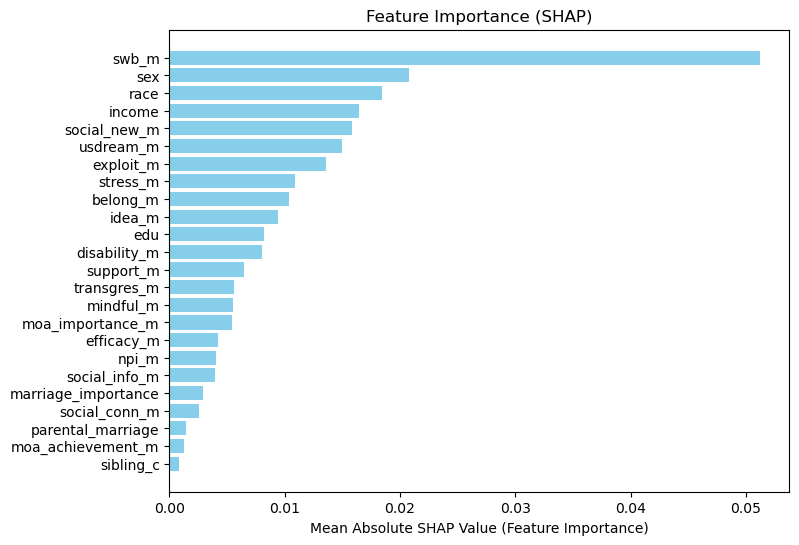

In [140]:
#| label: fig-SHAP
#| fig-cap: "Feature Importance Based on SHAP Values for the Keras Neural Network Model"
#| fig-num: true

plt.figure(figsize=(8,6))
plt.barh(shap_importance['Feature'], shap_importance['MeanAbsSHAP'], color='skyblue')
plt.xlabel("Mean Absolute SHAP Value (Feature Importance)")
plt.title("Feature Importance (SHAP)")
plt.show()

# Discussion

This project aimed to predict the presence of fatigue (Symptom 12) using psychosocial and demographic predictors through multiple supervised machine learning approaches, including neural networks. The models achieved moderate predictive accuracy, but early neural network models showed highly skewed probability distributions, with most predictions near 1.0. This suggests overconfidence and poor probability calibration, likely influenced by class imbalance. A refined neural network that incorporated dropout and early stopping displayed a more balanced probability distribution and better calibration, improving generalization.

Two neural network architectures were implemented and compared. The initial model included fewer hidden units and relied on a simpler configuration, while the refined model introduced more layers, increased units per layer, and incorporated dropout regularization to prevent overfitting. Although both models achieved similar test accuracy (87.2%) and AUC (~0.74), the refined model demonstrated more stable validation loss curves and a less skewed probability distribution. This suggests that architectural adjustments such as dropout may improve generalization and probability calibration, even when overall accuracy remains unchanged.

These findings highlight the importance of evaluating calibration and using metrics beyond raw accuracy, such as balanced accuracy and F1 score, when class imbalance is present. Future work should explore probability calibration techniques and richer data sources to enhance prediction quality. Clinically, better-calibrated models could support early identification of individuals at risk for fatigue, allowing for more targeted interventions.

# Conclusion
The models showed moderate accuracy in predicting fatigue, with the refined neural network providing the best-calibrated results. Class imbalance and overconfident predictions limited overall performance. Future work should focus on improving calibration, addressing imbalance, and testing on independent datasets to strengthen reliability.

# Reference


1. Grahe, J. E., Chalk, H. M., Cramblet Alvarez, L. D., Faas, C. S., Hermann, A. D., & McFall, J. P. (2018). Emerging adulthood measured at multiple institutions 2: The data [Data set]. Journal of Open Psychology Data, 6(1), Article 4. https://doi.org/10.5334/jopd.38

2. Clifford, C., Löwe, B., & Kohlmann, S. (2024). Characteristics and predictors of persistent somatic symptoms in patients with cardiac disease. Scientific Reports, 14(1), 25517. https://doi.org/10.1038/s41598-024-76554-z

3. Creed, F. (2022). The predictors of somatic symptoms in a population sample: The Lifelines cohort study. Psychosomatic Medicine, 84(9), 1056–1066. https://doi.org/10.1097/PSY.0000000000001101

4. Löwe, B., Andresen, V., Van Den Bergh, O., Huber, T. B., Von Dem Knesebeck, O., Lohse, A. W., Nestoriuc, Y., Schneider, G., Schneider, S. W., Schramm, C., Ständer, S., Vettorazzi, E., Zapf, A., Shedden-Mora, M., & Toussaint, A. (2022). Persistent SOMAtic symptoms ACROSS diseases—From risk factors to modification: Scientific framework and overarching protocol of the interdisciplinary SOMACROSS research unit (RU 5211). BMJ Open, 12(1), e057596. https://doi.org/10.1136/bmjopen-2021-057596

5. Tomenson, B., Essau, C., Jacobi, F., Ladwig, K. H., Leiknes, K. A., Lieb, R., Meinlschmidt, G., McBeth, J., Rosmalen, J., Rief, W., & Sumathipala, A. (2013). Total somatic symptom score as a predictor of health outcome in somatic symptom disorders. British Journal of Psychiatry, 203(5), 373–380. https://doi.org/10.1192/bjp.bp.112.114405

